In [1]:
import os
import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re

import setGPU

I0418 11:45:25.710868 139986118530880 file_utils.py:38] PyTorch version 1.4.0 available.
I0418 11:45:25.712228 139986118530880 file_utils.py:54] TensorFlow version 2.1.0 available.


setGPU: Setting GPU to: 0


In [2]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased")
model = TFBertForSequenceClassification.from_pretrained("bert-base-multilingual-uncased")

I0418 11:45:28.882362 139986118530880 tokenization_utils.py:418] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-vocab.txt from cache at /home/CompanyAI/.cache/torch/transformers/bb773818882b0524dc53a1b31a2cc95bc489f000e7e19773ba07846011a6c711.535306b226c42cebebbc0dabc83b92ab11260e9919e21e2ab0beb301f267b4c7
I0418 11:45:29.942812 139986118530880 configuration_utils.py:254] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json from cache at /home/CompanyAI/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.c7892120c5a9b21e515abc904e398dbabddf9510b122f659063cbf361fe16868
I0418 11:45:29.944377 139986118530880 configuration_utils.py:290] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "directionality": "bidi",
  "do_sample": false,
  "eos_token_ids": 

In [5]:
#random seed 고정

tf.random.set_seed(0)
np.random.seed(0)

BATCH_SIZE = 128
NUM_EPOCHS = 20
VALID_SPLIT = 0.2
MAX_LEN = 128
DATA_IN_PATH = 'data_in/ENG'
DATA_OUT_PATH = "data_out/ENG"

In [6]:
# Special Tokens
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# Test Tokenizers
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)

['[PAD]', '[SEP]', '[MASK]', '[UNK]', '[CLS]'] 
 [0, 102, 103, 100, 101]
[101, 1174, 26646, 49345, 13045, 35132, 25169, 47024, 117, 1170, 26646, 11376, 17360, 13212, 79427, 102]
[101, 29155, 10228, 102]
[CLS] 안녕하세요, 반갑습니다 [SEP]
[CLS] hello world [SEP]


# Bag of Words Meets Bags of Popcorn (Eng)

In [ ]:
import re
import json
import numpy as np
from bs4 import BeautifulSoup
import html5lib
from nltk.corpus import stopwords

In [16]:
# Load Train dataset
TRAIN_BOW_DF = os.path.join(DATA_IN_PATH, 'popcorn', 'labeledTrainData.tsv')

train_data_bow = pd.read_csv( TRAIN_BOW_DF, header = 0, delimiter = '\t', quoting = 3)
train_data_bow.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [9]:
# 4장의 기존 전처리를 follow up한다. 다만, Bert가 사전학습을 할 때 일반적으로 특수문자나 불용어를 제거하지 않기 때문에 제외한다.

stop_words = set(stopwords.words('english')) # 영어 불용어들의 set을 만든다.

def preprocessing( review, remove_stopwords = False ): 
    # 불용어 제거는 옵션으로 선택 가능하다.
    
    # 1. HTML 태그 제거
    review_text = BeautifulSoup(review, "html5lib").get_text()	

#     # 2. 영어가 아닌 특수문자들을 공백(" ")으로 바꾸기
#     review_text = re.sub("[^a-zA-Z]", " ", review_text)

    # 3. 대문자들을 소문자로 바꾸고 공백단위로 텍스트들 나눠서 리스트로 만든다.
    words = review_text.lower().split()

    if remove_stopwords: 
        # 4. 불용어들을 제거
    
        #영어에 관련된 불용어 불러오기
        stops = set(stopwords.words("english"))
        # 불용어가 아닌 단어들로 이루어진 새로운 리스트 생성
        words = [w for w in words if not w in stops]
        # 5. 단어 리스트를 공백을 넣어서 하나의 글로 합친다.	
        clean_review = ' '.join(words)

    else: # 불용어 제거하지 않을 때
        clean_review = ' '.join(words)

    return clean_review

# preprocessing(train_sent, remove_stopwords = False)

In [ ]:
train_data_bow_sents = []
train_data_bow_labels = []

for train_sent, train_label in zip(train_data_bow["review"], train_data_bow["sentiment"]):
    try:
        # Max Len의 경우 4장에 EDA값을 추출하였던 길이 174를 사용한다.
        token_sent = tokenizer.encode(preprocessing(train_sent[:174], remove_stopwords = False))
        
    except Exception as e:
        print("Error message: {}".format(e))
        print("sentence: {}".format(train_sent))
        continue
        
    train_data_bow_sents.append(token_sent) #append는 빼 놓고 한다.
    train_data_bow_labels.append(train_label)

train_data_bow_sent_pads = pad_sequences(train_data_bow_sents, maxlen=MAX_LEN, padding='post')
train_data_bow_labels = np.asarray(train_data_bow_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(train_data_bow_sent_pads), len(train_data_bow_labels)))

In [12]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [15]:
model_name = "tf2_bert_bag_of_words"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=5)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = model.fit(train_data_bow_sent_pads, train_data_bow_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback], validation_steps=2)

#steps_for_epoch

print(history.history)

data_out/tf2_bert_bag_of_words -- Folder already exists 

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
19968/20000 [============================>.] - ETA: 0s - loss: 0.5976 - accuracy: 0.6465
Epoch 00001: val_accuracy improved from -inf to 0.76172, saving model to data_out/tf2_bert_bag_of_words/weights.h5
20000/20000 [==============================] - 175s 9ms/sample - loss: 0.5973 - accuracy: 0.6467 - val_loss: 0.0243 - val_accuracy: 0.7617
Epoch 2/20
19968/20000 [============================>.] - ETA: 0s - loss: 0.4572 - accuracy: 0.7797
Epoch 00002: val_accuracy did not improve from 0.76172
20000/20000 [==============================] - 168s 8ms/sample - loss: 0.4569 - accuracy: 0.7800 - val_loss: 0.0248 - val_accuracy: 0.7578
Epoch 3/20
19968/20000 [============================>.] - ETA: 0s - loss: 0.3533 - accuracy: 0.8393
Epoch 00003: val_accuracy did not improve from 0.76172
20000/20000 [==============================] - 168s 8ms/sample - loss: 0.3532 - accuracy: 

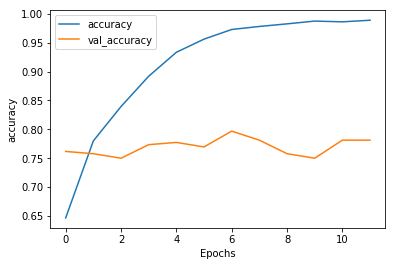

In [16]:
plot_graphs(history, 'accuracy')

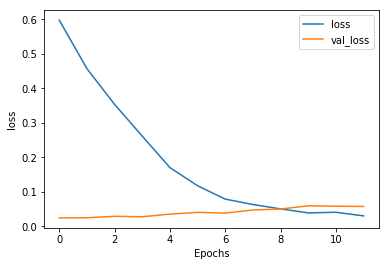

In [17]:
plot_graphs(history, 'loss')

# Bag of Words Test Dataset (제출 확인 필요)

In [17]:
TEST_BOW_DF = os.path.join(DATA_IN_PATH, 'popcorn', 'testData.tsv')

test_data_bow = pd.read_csv(TEST_BOW_DF, header=0, delimiter="\t", quoting=3)
test_data_bow.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [19]:
test_data_bow_sents = []
test_data_bow_idx = []

for test_sent, test_idx in zip(test_data_bow["review"], test_data_bow["id"]):
    try:
        # Max Len의 경우 4장에 EDA값을 추출하였던 길이 174를 사용한다.
        token_sent = tokenizer.encode(preprocessing(test_sent[:174], remove_stopwords = False))
        
    except Exception as e:
        print("Error message: {}".format(e))
        print("sentence: {}".format(test_sent))
        continue
        
    test_data_bow_sents.append(token_sent) #append는 빼 놓고 한다.
    test_data_bow_idx.append(test_idx)

test_data_bow_sent_pad = pad_sequences(test_data_bow_sents, maxlen=MAX_LEN, padding='post') # convert into numpy

In [22]:
print("num sents, labels {}, {}".format(len(test_data_bow_sent_pad), len(test_data_bow_idx)))

num sents, labels 25000, 25000


# Quora Simliarity (ENG)

In [63]:
# BASE PARAM

BATCH_SIZE = 256
NUM_EPOCHS = 50
VALID_SPLIT = 0.1
MAX_LEN = 31 * 2

In [56]:
# Load Train dataset
TRAIN_QUORA_DF = os.path.join(DATA_IN_PATH, 'quora', 'train.csv')

train_data_quora = pd.read_csv(TRAIN_QUORA_DF, header = 0)
train_data_quora.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [57]:
# Simliarty tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def sim_tokenizer(sent1, sent2, MAX_LEN):
    
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.

    encoded_dict = tokenizer.encode_plus(
        text = sent1,                      # Sentence to encode.
        text_pair = sent2,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids'] # Add the encoded sentence to the list.
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # diffenciate two sentences
    
    return input_id, attention_mask, token_type_id

In [59]:
# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근
FILTERS = "([~.,!?\"':;)(])"

change_filter = re.compile(FILTERS)

input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in zip(train_data_quora['question1'], train_data_quora['question2']):
    
    sent1 = re.sub(change_filter, "", str(sent1))
    sent2 = re.sub(change_filter, "", str(sent2))
    
    input_id, attention_mask, token_type_id = sim_tokenizer(sent1, sent2, MAX_LEN)
    
    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    
train_quora_input_ids = np.array(input_ids, dtype=int)
train_quora_attention_masks = np.array(attention_masks, dtype=int)
train_quora_type_ids = np.array(token_type_ids, dtype=int)
train_quora_inputs = (train_quora_input_ids, train_quora_attention_masks, train_quora_type_ids)

train_quora_labels = np.array(train_data_quora['is_duplicate'], dtype=int)

print("# sents: {}, # labels: {}".format(len(train_quora_input_ids), len(train_quora_labels)))

In [61]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model_name = "tf2_bert_quora"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=5)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = model.fit(train_quora_inputs, train_quora_labels, epochs=NUM_EPOCHS,
            batch_size=BATCH_SIZE, validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback], validation_steps=2)

#steps_for_epoch

print(history.history)

data_out/ENGtf2_bert_quora -- Folder already exists 

Train on 323432 samples, validate on 80858 samples
Epoch 1/50
323328/323432 [============================>.] - ETA: 0s - loss: 0.3238 - accuracy: 0.8528
Epoch 00001: val_accuracy improved from -inf to 0.89648, saving model to data_out/ENGtf2_bert_quora/weights.h5
323432/323432 [==============================] - 1261s 4ms/sample - loss: 0.3238 - accuracy: 0.8528 - val_loss: 0.0016 - val_accuracy: 0.8965
Epoch 2/50
323328/323432 [============================>.] - ETA: 0s - loss: 0.2346 - accuracy: 0.9004
Epoch 00002: val_accuracy improved from 0.89648 to 0.90234, saving model to data_out/ENGtf2_bert_quora/weights.h5
323432/323432 [==============================] - 1259s 4ms/sample - loss: 0.2346 - accuracy: 0.9004 - val_loss: 0.0014 - val_accuracy: 0.9023
Epoch 3/50
215808/323432 [===================>..........] - ETA: 6:55 - loss: 0.1820 - accuracy: 0.9255

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')

# Quora Simliarity TEST

In [ ]:
# 테스트 데이터셋 로드

TEST_QUORA_DF = os.path.join(DATA_IN_PATH, 'quora', 'test.csv')

test_data_quora = pd.read_csv(TEST_QUORA_DF, header = 0)

test_data_quora = pd.read_csv(TEST_QUORA_DF, header=0, delimiter="\t", quoting=3)
test_data_quora.head()

In [ ]:
# Test dataset 전처리

input_ids = []
attention_masks = []
token_type_ids = []

for sent1, sent2 in zip(test_data_quora['question1'], test_data_quora['question2']):
    
    sent1 = re.sub(change_filter, "", str(sent1))
    sent2 = re.sub(change_filter, "", str(sent2))
    
    input_id, attention_mask, token_type_id = quora_tokenizer(sent1, sent2, MAX_LEN)
    
    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    
test_quora_input_ids = np.array(input_ids, dtype=int)
test_quora_attention_masks = np.array(attention_masks, dtype=int)
test_quora_type_ids = np.array(token_type_ids, dtype=int)
test_quora_inputs = (train_quora_input_ids, train_quora_attention_masks, train_quora_type_ids)

print("# sents: {}".format(len(test_quora_input_ids))

In [ ]:
# 테스트 값 예측하기

predictions = model.predict(test_quora_inputs, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

output = pd.DataFrame( data={"test_id":test_data_quora['test_id'], "is_duplicate": list(predictions)} )
output.to_csv("bert_predict.csv", index=False, quoting=3)